<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/master/Notebook_GradCam_TimeLapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import os
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import shutil
import keras
import pathlib
import gc
import glob
import imageio
import tensorflow_docs.vis.embed as embed
from PIL import Image, ImageFont
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from skimage.segmentation import mark_boundaries
from numpy import mean, std
import matplotlib.cm as cm
from keras import metrics
from scipy import stats
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, Adamax, Lion
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Activation, Reshape, Dropout, Dense, GlobalAveragePooling2D, Flatten, Rescaling, Conv2D, BatchNormalization, MaxPooling2D

In [ ]:
# GLOBAL VARIABLE
IMG_SIZE = 256
CHANEL = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANEL)
BATCH_SIZE = 4
STOPPING_PATIENCE = 250
REDUCTION_PATIENCE = 15
EPOCHS = 168 # cause 24 images/s
VERBOSE = 1
SEED = 123
POLICE_SIZE = 18 # Taille de la police pour les plot
plt.rcParams.update({'font.size': POLICE_SIZE})
plt.rcParams["figure.autolayout"] = True

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# CALLBACKS
def callbacks(modelName) :
  EARLY_STOPPING = \
          EarlyStopping(
              monitor='val_loss',
              patience=STOPPING_PATIENCE,
              verbose=VERBOSE,
              mode='auto')

  LR_REDUCTION = \
          ReduceLROnPlateau(
              monitor='val_accuracy',
              patience=REDUCTION_PATIENCE,
              verbose=VERBOSE,
              factor=0.5,
              min_lr=0.000001)

  CHECKPOINT = ModelCheckpoint(f"Saved_Model/{modelName}.h5", monitor='val_accuracy', verbose=VERBOSE,
      save_best_only=True, mode='auto', save_freq="epoch")

  CALLBACKS = [EARLY_STOPPING, LR_REDUCTION, CHECKPOINT]
  return CALLBACKS

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.F1Score(threshold=0.5, dtype='float32', name='f1_score')
      ]

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/Colab Notebooks/
%mkdir -p HAI923/Résultats/Entrainement/
%mkdir -p HAI923/Saved_Model/
%cd HAI923/
%pwd

import zipfile
if not(os.path.exists('Tiger-Fox-Elephant/')) :
  if not(os.path.exists('Tiger-Fox-Elephant.zip')) :
    !wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
  with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref :
    zip_ref.extractall()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/HAI923


In [ ]:
def create_dataset(my_path, my_classes, gray=False, onehot=False) :
  X,y=create_X_y(my_path, my_classes, gray, onehot)
  print("Les classes : ", my_classes)
  print("Nombres de données : ", X.shape[0])
  print ("Résolution des images : ", X[0].shape)
  X=X.astype('float')
  X=X/255.0
  return X,y

def create_training_data(path_data, list_classes, gray=False):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        if gray == False :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2RGB)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        else :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2GRAY)
          equ = cv2.equalizeHist(new_array)
          new_array = np.hstack((new_array,equ))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y(path_data, list_classes, gray=False, onehot=False):
      training_data=create_training_data(path_data, list_classes, gray)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      if gray == False :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      else :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
      if onehot == False :
        y=np.array(y, dtype=np.float32)
      else :
        y=to_categorical(y, dtype=np.float32) #onehot

      return X,y

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'Tiger_negative_class']
Nombres de données :  200
Résolution des images :  (256, 256, 3)
Taille de X_train : 140, Taille de X_val : 30, Taille de X_test : 30


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[last_conv_layer].output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    del(last_conv_layer_output)
    del(pooled_grads)
    del(grads)
    del(grad_model)
    gc.collect()

    return heatmap.numpy()

def display_gradcam(img, heatmap, i, alpha=0.4):

    img = img * 255
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    del(jet_heatmap)
    del(jet_colors)
    del(jet)
    del(heatmap)
    del(img)
    gc.collect()

    # Return the superimposed image
    return superimposed_img

def Grad_cam(model, total, picture) :
  # Iterate through the layers to find convolutional layers
  list_layer_conv = []

  for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
      list_layer_conv.append(i)

  if not list_layer_conv :
    print("Error: No convolutional layers found in the model.")
    sys.exit(1)

  last_conv_layer = list_layer_conv[-1]

  # Transform the list into a single ndarray
  picture = np.array(picture)

  # Add an extra dimension to the ndarray
  picture = np.expand_dims(picture, axis=0)

  heatmap = make_gradcam_heatmap(picture, model, last_conv_layer)

  # display heatmap
  image = display_gradcam(picture.reshape(IMG_SIZE, IMG_SIZE, CHANEL), heatmap, i+1)

  # Add an epoch counter to the top middle of the plot
  plt.text(0.5, 0.95, f'Epoch: {total}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10, color='white')


  plt.axis('off')
  plt.imshow(image)
  plt.savefig(f'Résultats/baseline/Grad_cam_video/class_{my_classes[1]}_1_{total}.png', bbox_inches='tight', pad_inches=0)
  plt.show()

  del(heatmap)
  del(image)
  del(picture)
  gc.collect()

In [ ]:
def baseline() :
  model = Sequential()

  # ---- Conv / Pool N°2
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # Flattening
  model.add(Flatten())
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='elu', kernel_regularizer=L1L2(1e-5)))  # Add L1L2 regularization
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='elu', kernel_regularizer=L1L2(1e-5)))  # Add L1L2 regularization
  model.add(Dropout(0.25))

  # Couche de sortie : classification => softmax sur le nombre de classe / sigmoid pour classe = 2
  model.add(Dense(units=1, activation='sigmoid'))

  # compilation du model de classification
  opt = Lion(learning_rate=1e-05)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

  return model

In [ ]:
def TlModel(ModelName) :

  base_model = ModelName(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')

  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.25)(x)
  x = Dense(128, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.25)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  model.compile(Lion(learning_rate=.00001), loss='binary_crossentropy', metrics=METRICS)

  return model

In [ ]:
def trainModelNumpyAugment(index, ModelName) :
  os.makedirs(f'Résultats/{ModelName.__name__}/Grad_cam_video/', exist_ok=True)

  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.05,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  datagen.fit(X_train)

  model = TlModel(ModelName.__name__)

  histories = []
  # 1 er training
  histories.append(model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                      epochs=1, batch_size=BATCH_SIZE,
                      validation_data=(X_val, Y_val)))

  total = 1

  # Other training
  for i in range(EPOCHS-1) :

    picture = X_test[index]

    # function call
    Grad_cam(model, total, picture)

    total+=1
    model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                            epochs=histories[-1].epoch[-1]+2, validation_data=(X_val, Y_val), batch_size=BATCH_SIZE,
                            initial_epoch=histories[-1].epoch[-1]+1)

  # evaluate du modele
  loss, acc, pre, rec, fscore = model.evaluate(X_test, Y_test, verbose=VERBOSE)

0.0


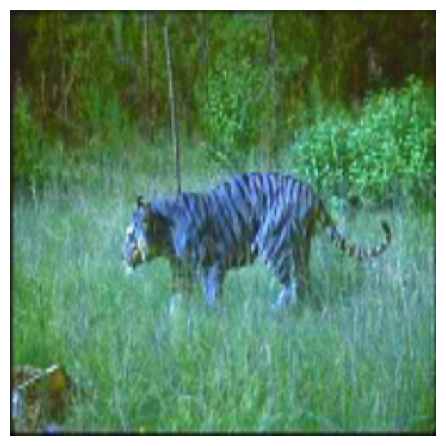

In [ ]:
plt.axis('off')
index=2
print(Y_test[index])
plt.imshow(X_test[index])

In [ ]:
ModelName=VGG16()
trainModelNumpyAugment(index, ModelName)

In [ ]:
anim_file = 'GradCamTimeLapse.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f'Résultats/{ModelName.__name__}/Grad_cam_video/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)